In [25]:
#import libraries
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import lognorm
from sklearn.cluster import KMeans
import os
import joblib
warnings.filterwarnings('ignore')

In [26]:
data = pd.read_csv('/Users/uddashyakumar/Desktop/multyfi/NIFTY50.csv')

# Convert the 'datetime' column to datetime format
data['datetime'] = pd.to_datetime(data['datetime'])

# Filter data for the years 2017 to 2019
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2019-12-31')
filtered_data = data[(data['datetime'] >= start_date) & (data['datetime'] <= end_date)]

filtered_data.head(5)


,symbol,datetime,open,high,low,close,volume
0,NIFTY50,2017-07-17 09:15:00,9908.15,9908.50,9900.50,9900.50,0
1,NIFTY50,2017-07-17 09:16:00,9901.90,9905.85,9899.50,9904.35,0
2,NIFTY50,2017-07-17 09:17:00,9904.45,9906.80,9903.30,9903.30,0
3,NIFTY50,2017-07-17 09:18:00,9903.35,9908.90,9903.35,9907.80,0
4,NIFTY50,2017-07-17 09:19:00,9907.00,9911.60,9905.35,9910.15,0


In [27]:

# Select only the 'close' column
data = filtered_data[['close']]
data.head(5)
data.shape

(226422, 1)

In [28]:
# Set the 'datetime' column as the index
filtered_data.set_index('datetime', inplace=True)

# Make sure the index is in DatetimeIndex format
filtered_data.index = pd.DatetimeIndex(filtered_data.index)

# Resample the data on a weekly basis and calculate OHLCV values
monthly_resampled_data = filtered_data.resample('M').apply({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Display the resampled data
print(monthly_resampled_data.head())
monthly_resampled_data.shape

                open      high       low     close  volume
datetime                                                  
2017-07-31   9908.15  10113.80   9817.95  10076.95       0
2017-08-31  10101.05  10136.30   9687.30   9915.80       0
2017-09-30   9937.65  10178.50   9688.40   9782.95       0
2017-10-31   9893.30  10384.25   9831.15  10340.00       0
2017-11-30  10390.35  10490.40  10094.20  10229.45       0


(30, 5)

In [29]:
# Resample the data on a weekly basis and calculate OHLCV values
weekly_resampled_data = filtered_data.resample('W').apply({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Display the resampled data
print(weekly_resampled_data.head())
weekly_resampled_data.shape

                open      high      low     close  volume
datetime                                                 
2017-07-23   9908.15   9928.20  9817.95   9914.15       0
2017-07-30   9936.80  10113.80  9919.90  10002.95       0
2017-08-06  10034.70  10136.30  9989.80  10068.50       0
2017-08-13  10074.80  10087.25  9687.30   9712.95       0
2017-08-20   9755.75   9945.55  9755.75   9834.45       0


(129, 5)

In [30]:
# Fit a lognormal distribution to the 'close' data
mu_weekly, sigma_weekly = np.log(weekly_resampled_data['close']).mean(), np.log(weekly_resampled_data['close']).std()
s_weekly = np.random.lognormal(mu_weekly, sigma_weekly, len(weekly_resampled_data))

In [31]:
# Fit a lognormal distribution to the 'close' data
mu, sigma = np.log(data['close']).mean(), np.log(data['close']).std()
s = np.random.lognormal(mu, sigma, len(data))

In [32]:
# Fit a lognormal distribution to the 'close' data
mu_monthly, sigma_monthly = np.log(monthly_resampled_data['close']).mean(), np.log(monthly_resampled_data['close']).std()
s_monthly = np.random.lognormal(mu_monthly, sigma_monthly, len(monthly_resampled_data))


(226422, 1)

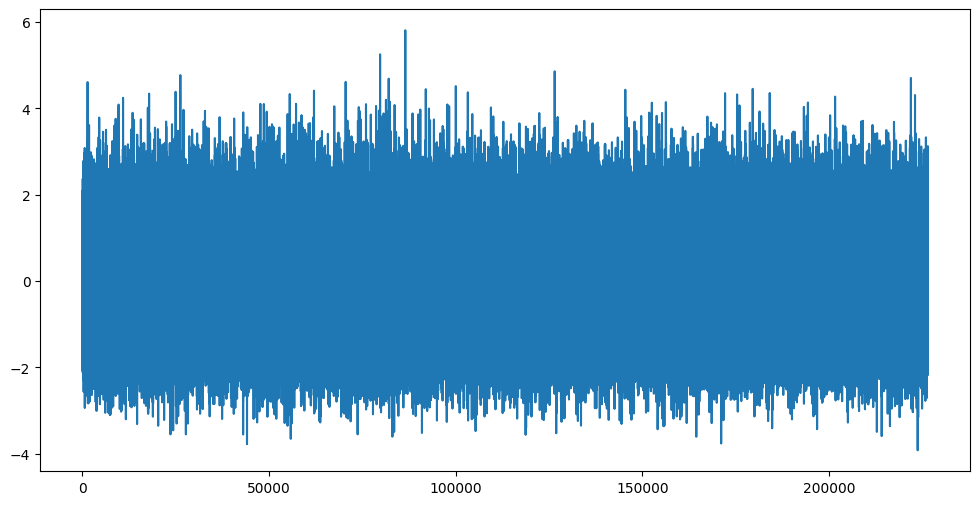

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_for_scaling = s
data_for_scaling = data_for_scaling.reshape(-1, 1)

data_scaled = scaler.fit_transform(data_for_scaling)

data_scaled_df = pd.DataFrame(data_scaled, columns=['log close'])

plt.figure(figsize=(12,6))

plt.plot(data_scaled_df['log close'])
data_scaled_df.shape

(129, 1)

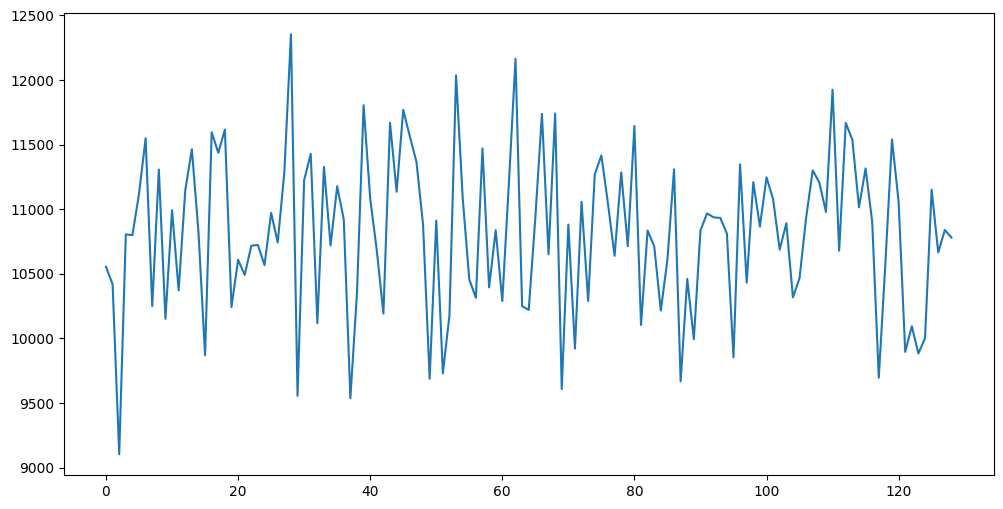

In [34]:
data_for_scaling_weekly = s_weekly
data_for_scaling_weekly = data_for_scaling_weekly.reshape(-1, 1)

data_scaled_weekly = scaler.fit_transform(data_for_scaling_weekly)

data_scaled_weekly_df = pd.DataFrame(data_for_scaling_weekly, columns=['log close'])

plt.figure(figsize=(12,6))

plt.plot(data_scaled_weekly_df['log close'])
data_scaled_weekly.shape

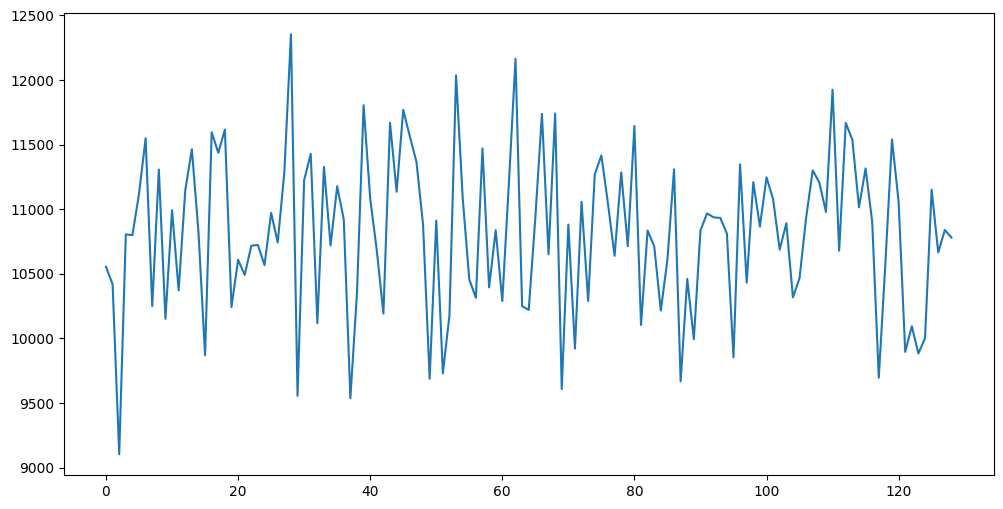

In [35]:
data_for_scaling_monthly = s_monthly
data_for_scaling_monthly = data_for_scaling_monthly.reshape(-1, 1)

data_scaled_monthly = scaler.fit_transform(data_for_scaling_monthly)

data_scaled_monthly_df = pd.DataFrame(data_for_scaling_weekly, columns=['log close'])

plt.figure(figsize=(12,6))

plt.plot(data_scaled_monthly_df['log close'])

In [36]:
# Check if the trained model file exists, if not, fit the KMeans model and save it
if not os.path.exists('kmeans_model.joblib'):
    model = KMeans(n_clusters=3, init='k-means++')
    model.fit(data_scaled_df)
    # Save the trained model to a file
    joblib.dump(model, 'kmeans_model.joblib')
else:
    # Load the trained model from the file
    model = joblib.load('kmeans_model.joblib')

In [37]:
data_scaled_df['Cluster'] = model.predict(data_scaled_df)
data_scaled_df.head(5)

,log close,Cluster
0,1.008065,2
1,0.960243,2
2,1.291859,2
3,2.086909,2
4,-0.755900,0


In [38]:
# Check if the trained model file exists for weekly data, if not, fit the KMeans model and save it
if not os.path.exists('kmeans_weekly_model.joblib'):
    model_weekly = KMeans(n_clusters=3, init='k-means++')
    model_weekly.fit(data_scaled_weekly_df)
    # Save the trained model to a file
    joblib.dump(model_weekly, 'kmeans_weekly_model.joblib')
else:
    # Load the trained model from the file
    model_weekly = joblib.load('kmeans_weekly_model.joblib')

In [39]:
data_scaled_weekly_df['Cluster'] = model_weekly.predict(data_scaled_weekly_df)
data_scaled_weekly_df.head(5)

,log close,Cluster
0,10554.119559,1
1,10418.039992,1
2,9103.526622,1
3,10804.730255,0
4,10799.089737,0


In [40]:
# Check if the trained model file exists for weekly data, if not, fit the KMeans model and save it
if not os.path.exists('kmeans_monthly_model.joblib'):
    model_monthly = KMeans(n_clusters=3, init='k-means++')
    model_monthly.fit(data_scaled_monthly_df)
    # Save the trained model to a file
    joblib.dump(model_monthly, 'kmeans_monthly_model.joblib')
else:
    # Load the trained model from the file
    model_monthly = joblib.load('kmeans_monthly_model.joblib')

In [41]:
data_scaled_monthly_df['Cluster'] = model_monthly.predict(data_scaled_monthly_df)
data_scaled_monthly_df.head(5)
data_scaled_monthly_df.shape

(129, 2)

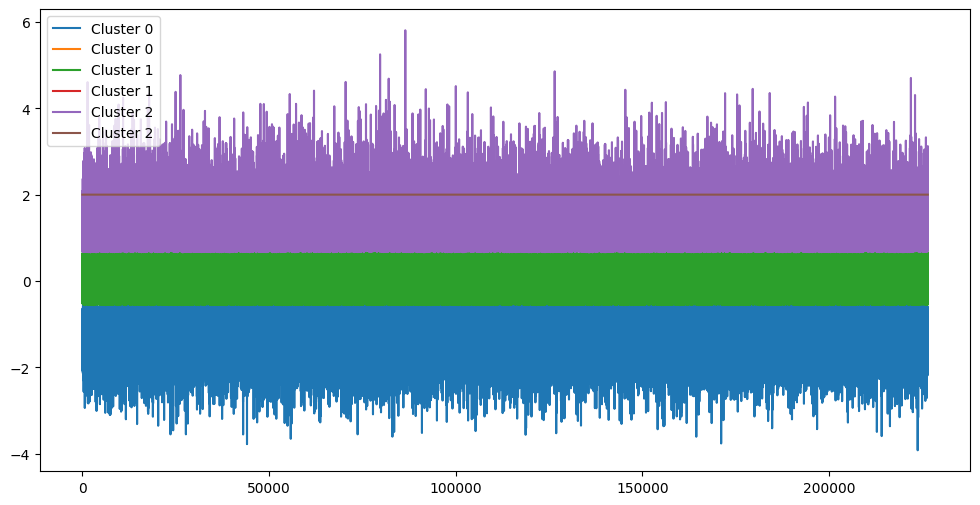

In [42]:
plt.figure(figsize=(12, 6))
for cluster in range(3):
    plt.plot(data_scaled_df[data_scaled_df['Cluster'] == cluster],
                label=f'Cluster {cluster}')
plt.legend()
plt.show()


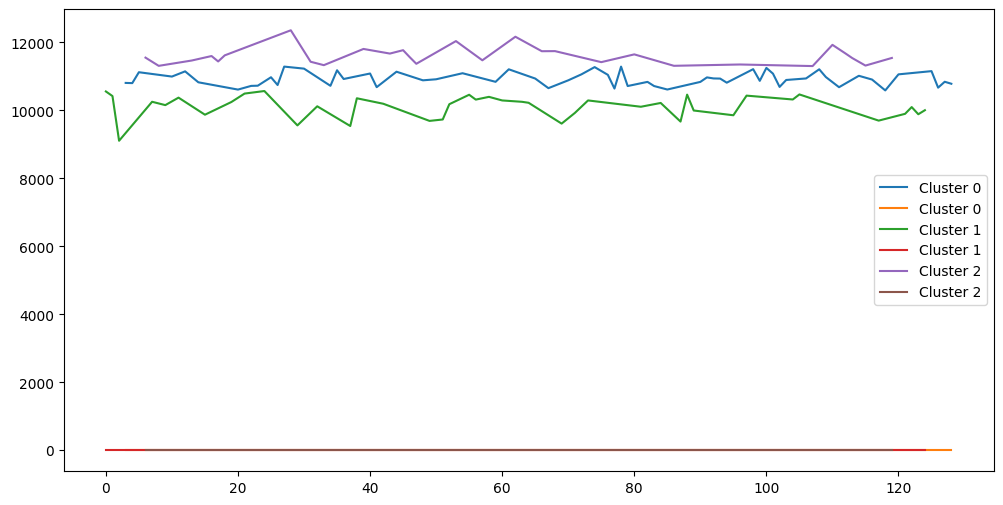

In [43]:
plt.figure(figsize=(12, 6))
for cluster in range(3):
    plt.plot(data_scaled_weekly_df[data_scaled_weekly_df['Cluster'] == cluster],
                label=f'Cluster {cluster}')
plt.legend()
plt.show()


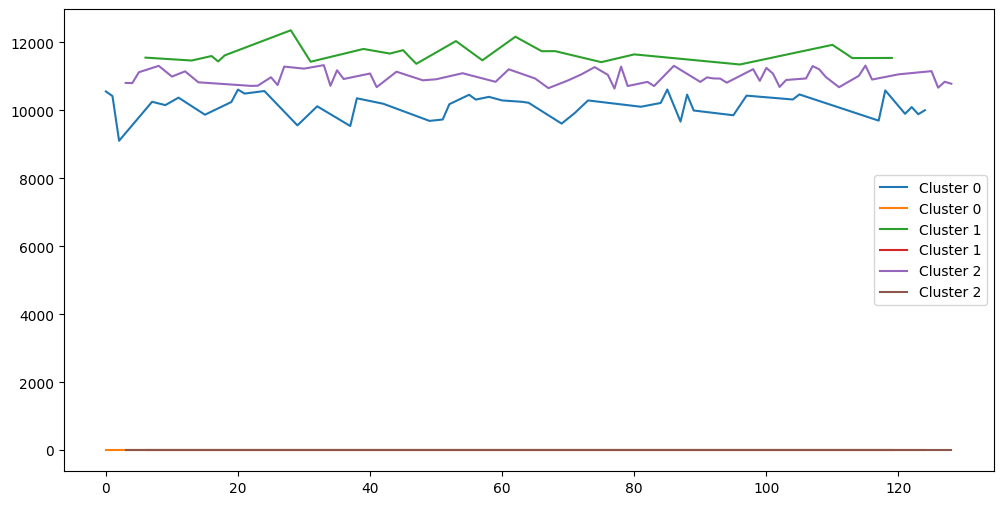

In [44]:
plt.figure(figsize=(12, 6))
for cluster in range(3):
    plt.plot(data_scaled_monthly_df[data_scaled_monthly_df['Cluster'] == cluster],
                label=f'Cluster {cluster}')
plt.legend()
plt.show()


In [45]:
# Function to predict cluster 
def predict_cluster(closing_price):

  scaled_data = scaler.transform([[closing_price]])

  prediction = model.predict(scaled_data)
  if prediction[0]==0:
    regime='Bearish'
  elif prediction[0]==2:
    regime='Consolidated'
  else:
    regime='Bullish'
  return regime


In [46]:
# Take input
closing_price_daily = float(input("Enter Daily closing price: "))

# Predict cluster
cluster_daily = predict_cluster(closing_price_daily)

# Print result  
print(f"Closing price {closing_price_daily} belongs to cluster:", cluster_daily)

Closing price 10000.0 belongs to cluster: Bearish


In [47]:
# Take input
closing_price_weekly = float(input("Enter Weekly closing price: "))

# Predict cluster
cluster_weekly = predict_cluster(closing_price_weekly)

# Print result  
print(f"Closing price {closing_price_weekly} belongs to cluster:", cluster_weekly)

Closing price 1000.0 belongs to cluster: Bearish


In [48]:
# Take input
closing_price_monthly = float(input("Enter Monthly closing price: "))

# Predict cluster
cluster_monthly = predict_cluster(closing_price_monthly)

# Print result  
print(f"Closing price {closing_price_monthly} belongs to cluster:", cluster_monthly)

Closing price 1000.0 belongs to cluster: Bearish
